<img src="../images/xarray_aws_zarr.png" />

# Plotting HRRR 2-meter temperatures

## Overview
1. Access archived HRRR data hosted on AWS in Zarr format
2. Visualize one of the variables (2m temperature) at an analysis time

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| Xarray Lessons 1-9| Necessary | |

* **Time to learn**: 30 minutes
***

## Imports

In [1]:
import xarray as xr
import s3fs
import metpy
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## What is Zarr?

So far we have used Xarray to work with gridded datasets in NetCDF and GRIB formats. Zarr is a relatively new data format. It is particularly relevant in the following two scenarios:
1. Datasets that are stored in what's called *object store*. This is a commonly-used storage method for cloud providers, such as Amazon, Google, and Microsoft.
2. Datasets that are typically too large to load into memory all at once.

The [Pangeo](https://pangeo.io) project specifically recommends [Zarr as the Xarray-amenable data format of choice in the cloud](https://pangeo.io/data.html):
>
>"Our current preference for storing multidimensional array data in the cloud is the Zarr format. Zarr is a new storage format which, thanks to its simple yet well-designed specification, makes large datasets easily accessible to distributed computing. In Zarr datasets, the arrays are divided into chunks and compressed. These individual chunks can be stored as files on a filesystem or as objects in a cloud storage bucket. The metadata are stored in lightweight .json files. Zarr works well on both local filesystems and cloud-based object stores. Existing datasets can easily be converted to zarr via xarray’s zarr functions."


## Access archived HRRR data hosted on AWS in Zarr format</span>

For a number of years, the [Mesowest](https://mesowest.utah.edu/) group at the University of Utah has hosted an archive of data from NCEP's High Resolution Rapid Refresh model. This data, originally in GRIB-2 format, has been converted into Zarr and is freely available "in the cloud", on [Amazon Web Service's Simple Storage Service](https://aws.amazon.com/s3/), otherwise known as **S3**. Data is stored in S3 in a manner akin to (but different from) a Linux filesystem, using a [*bucket* and *object*](https://docs.aws.amazon.com/AmazonS3/latest/userguide/Welcome.html#CoreConcepts) model.

To interactively browse the contents of this archive, go to this link: [HRRRZarr File Browser on AWS](https://hrrrzarr.s3.amazonaws.com/index.html)

To access Zarr-formatted data stored in an S3 bucket, we follow a 3-step process:
1. Create URL(s) pointing to the bucket and object(s) that contain the data we want
1. Create *map(s)* to the object(s) with the **s3fs** library's `S3Map` method
1. Pass the *map(s)* to Xarray's `open_dataset` or `open_mfdataset` methods, and specify `zarr` as the format, via the `engine` argument.

<div class="alert alert-info">
A quirk in how these grids were converted from GRIB2 to Zarr means that the dimension variables are defined one directory up from where the data variables are. Thus, our strategy is to use Xarray's <code>open_mfdataset</code> method and pass in two AWS S3 file references to these two corresponding directories.
</div>

Create the URLs

In [2]:
date = '20211016'
hour = '21'
var = 'TMP'
level = '2m_above_ground'
url1 = 's3://hrrrzarr/sfc/' + date + '/' + date + '_' + hour + 'z_anl.zarr/' + level + '/' + var + '/' + level
url2 = 's3://hrrrzarr/sfc/' + date + '/' + date + '_' + hour + 'z_anl.zarr/' + level + '/' + var
print(url1)
print(url2)

s3://hrrrzarr/sfc/20211016/20211016_21z_anl.zarr/2m_above_ground/TMP/2m_above_ground
s3://hrrrzarr/sfc/20211016/20211016_21z_anl.zarr/2m_above_ground/TMP


<div class="alert alert-info">
    In this case, <b>hrrrzarr</b> is the S3 <i>bucket</i> name. <b>2m_above_ground</b> and <b>TMP</b> are both <i>objects</i> within the <b>bucket</b>. The former object has the 2-meter temperature array, while the latter contains the coordinate arrays of the spatial dimensions of 2m temperature (i.e., x and y).
</div>

Create the S3 maps from the S3 object store.

In [3]:
fs = s3fs.S3FileSystem(anon=True)
file1 = s3fs.S3Map(url1, s3=fs)
file2 = s3fs.S3Map(url2, s3=fs)

Use Xarray's `open_mfdataset` to create a `Dataset` from these two S3 objects.

In [4]:
ds = xr.open_mfdataset([file1,file2], engine='zarr')

Examine the dataset.

In [5]:
ds

<xarray.Dataset>
Dimensions:                  (projection_x_coordinate: 1799,
                              projection_y_coordinate: 1059)
Coordinates:
  * projection_x_coordinate  (projection_x_coordinate) float64 -2.698e+06 ......
  * projection_y_coordinate  (projection_y_coordinate) float64 -1.587e+06 ......
Data variables:
    TMP                      (projection_y_coordinate, projection_x_coordinate) float16 dask.array<chunksize=(150, 150), meta=np.ndarray>
    forecast_period          timedelta64[ns] ...
    forecast_reference_time  datetime64[ns] ...
    height                   float64 ...
    pressure                 float64 ...
    time                     datetime64[ns] ...

<div class="alert alert-warning">
The projection information for the HRRR was not readily found in the Zarr representation, so we will need to define the relevant parameters explicitly from other sources, shown below.
</div>

### HRRR Grid Navigation: 
     PROJECTION:          LCC                 
     ANGLES:                38.5   -97.5    38.5
     GRID SIZE:             1799    1059
     LL CORNER:            21.1381 -122.7195
     UR CORNER:            47.8422  -60.9168

In [6]:
lon1 = -97.5
lat1 = 38.5
slat = 38.5
projData= ccrs.LambertConformal(central_longitude=lon1,
                             central_latitude=lat1,
                             standard_parallels=[slat,slat],globe=ccrs.Globe(semimajor_axis=6371229,
                                        semiminor_axis=6371229))

<div class="alert alert-warning"><b>Note: </b>
    The HRRR's projection assumes a <i>spherical earth</i>, whose semi-major/minor axes are both equal to 6371.229 km. We therefore need to explicitly define a <code>Globe</code> in Cartopy with these values.
</div>

Examine the dataset's coordinate variables. Each x- and y- value represents distance in meters from the central latitude and longitude.

In [7]:
ds.coords

Coordinates:
  * projection_x_coordinate  (projection_x_coordinate) float64 -2.698e+06 ......
  * projection_y_coordinate  (projection_y_coordinate) float64 -1.587e+06 ......

Create an object pointing to the dataset's data variable.

In [8]:
airTemp = ds.TMP

When we examine the object, we see that it is a special type of `DataArray` ... a *Dask* array.

In [9]:
airTemp

<xarray.DataArray 'TMP' (projection_y_coordinate: 1059,
                         projection_x_coordinate: 1799)>
dask.array<open_dataset-57ef55df3f4a8b18d29905c1d0898b84TMP, shape=(1059, 1799), dtype=float16, chunksize=(150, 150), chunktype=numpy.ndarray>
Coordinates:
  * projection_x_coordinate  (projection_x_coordinate) float64 -2.698e+06 ......
  * projection_y_coordinate  (projection_y_coordinate) float64 -1.587e+06 ......
Attributes:
    GRIB_PARAM:   [2, 0, 0, 0]
    coordinates:  height forecast_reference_time pressure time forecast_period
    long_name:    2m_above_ground/TMP
    units:        K

When we examine the object, we see that it is a special type of `DataArray` ... a *[DaskArray](https://docs.dask.org/en/latest/array.html)*.

## Sidetrip: Dask

<div class="alert alert-info">Dask is a Python library that is especially well-suited for handling very large datasets (especially those that are too large to fit into RAM) and is nicely integrated with Xarray. We're going to defer a detailed exploration of Dask for now. But suffice it to say that when we use <code>open_mfdataset</code>, the resulting objects are <i>Dask</i> objects.
</div>

MetPy supports Dask arrays, and so performing a unit conversion is straightforward.

In [10]:
airTemp = airTemp.metpy.convert_units('degC')

Verify that the object has the unit change

In [11]:
airTemp

<xarray.DataArray 'TMP' (projection_y_coordinate: 1059,
                         projection_x_coordinate: 1799)>
<Quantity(dask.array<truediv, shape=(1059, 1799), dtype=float16, chunksize=(150, 150), chunktype=numpy.ndarray>, 'degree_Celsius')>
Coordinates:
  * projection_x_coordinate  (projection_x_coordinate) float64 -2.698e+06 ......
  * projection_y_coordinate  (projection_y_coordinate) float64 -1.587e+06 ......
Attributes:
    GRIB_PARAM:   [2, 0, 0, 0]
    coordinates:  height forecast_reference_time pressure time forecast_period
    long_name:    2m_above_ground/TMP

Similar to what we did for datasets whose projection-related coordinates were latitude and longitude, we define objects pointing to x and y now, so we can pass them to the plotting functions.

In [12]:
x = airTemp.projection_x_coordinate
y = airTemp.projection_y_coordinate

## Visualize 2m temperature at an analysis time

First, just use Xarray's `plot` function to get a quick look to verify that things look right.

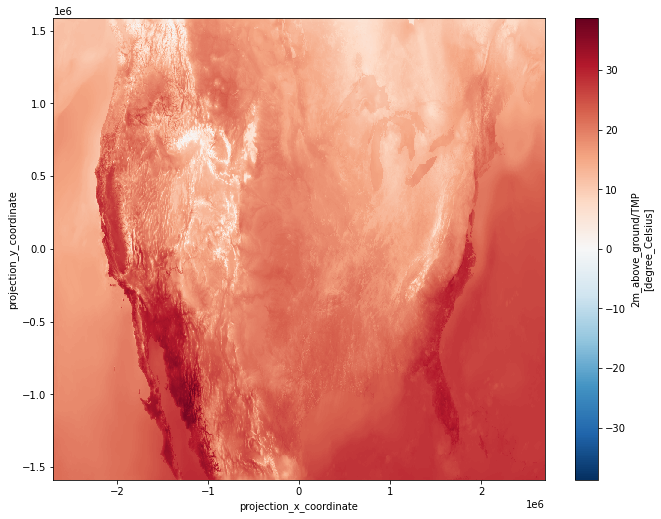

In [13]:
airTemp.plot(figsize=(11,8.5))

To facilitate the bounds of the contour intervals, obtain the min and max values from this `DataArray`.

<div class="alert alert-warning">
    A Dask array is even more <i>lazy</i> in terms of its data loading than a basic <code>DataArray</code> in Xarray. If we want to perform a computation on this array, e.g. calculate the mean, min, or max, note that we don't get a result straightaway ... we get another Dask array.
</div>

In [14]:
airTemp.min()

<xarray.DataArray 'TMP' ()>
<Quantity(dask.array<_nanmin_skip-aggregate, shape=(), dtype=float16, chunksize=(), chunktype=numpy.ndarray>, 'degree_Celsius')>

<div class="alert alert-info">
With Dask arrays, applying the min and max functions doesn't actually do the computation ... instead, it is creating a <i>task graph</i> which describes how the computations would be launched. You will need to call Dask's <code>compute</code> function to actually trigger the computation.   
</div>

In [15]:
minTemp = airTemp.min().compute()
maxTemp = airTemp.max().compute()

In [16]:
minTemp.values, maxTemp.values

(array(-4.75, dtype=float16), array(38.75, dtype=float16))

Based on the min and max, define a range of values used for contouring. Let's invoke NumPy's `floor` and `ceil`(ing) functions so these values conform to whatever variable we are contouring.

In [17]:
fint = np.arange(np.floor(minTemp.values),np.ceil(maxTemp.values) + 2, 2)

In [18]:
fint

array([-5., -3., -1.,  1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19.,
       21., 23., 25., 27., 29., 31., 33., 35., 37., 39.])

<div class="alert alert-warning">
 For a single map, setting the contour fill values as we did above is appropriate. But if you were producing a series of maps that span a range of times, a consistent (and thus wider) range of values would be better.
</div>

## Plot the map
We'll define the plot extent to nicely encompass the HRRR's spatial domain.

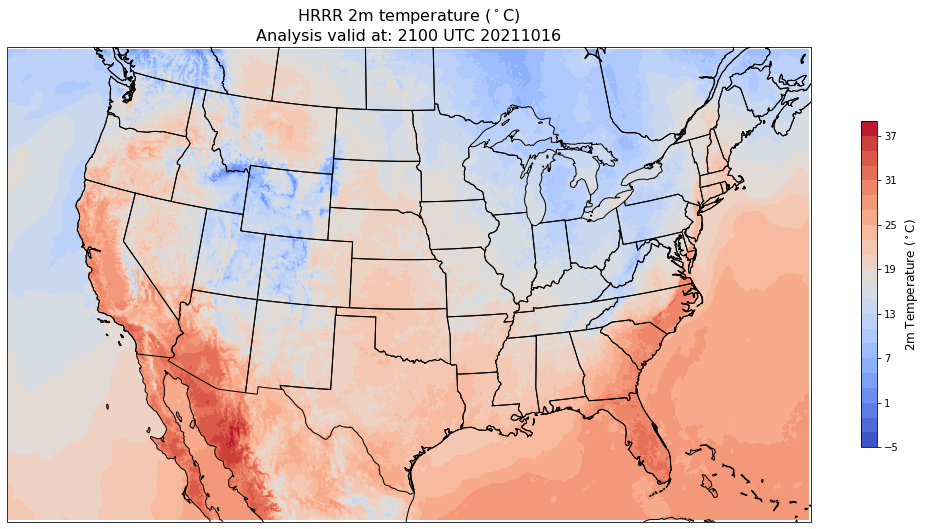

In [19]:
latN = 50.4
latS = 24.25
lonW = -123.8
lonE = -71.2

res = '50m'

fig = plt.figure(figsize=(18,12))
ax = plt.subplot(1,1,1,projection=projData)
ax.set_extent ([lonW,lonE,latS,latN],crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.STATES.with_scale(res))

# Add the title
tl1 = str('HRRR 2m temperature ($^\circ$C)')
tl2 = str('Analysis valid at: '+ hour + '00 UTC ' + date  )
plt.title(tl1+'\n'+tl2,fontsize=16)

# Contour fill
CF = ax.contourf(x,y,airTemp,levels=fint,cmap=plt.get_cmap('coolwarm'))
# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig.colorbar(CF,shrink=0.5)
cbar.set_label(r'2m Temperature ($^\circ$C)', size='large')

---
## Summary
* Xarray can access datasets in Zarr format, which is ideal for a cloud-based object store system such as S3.
* Xarray and MetPy both support *Dask*, a library that is particularly well-suited for very large datasets.

## What's next?
On your own, browse the [**hrrrzarr**](https://hrrrzarr.s3.amazonaws.com/index.html) S3 bucket. Try making maps for different variables and/or different times.

## Resources and References

1. [HRRR in Zarr format](https://mesowest.utah.edu/html/hrrr/)
1. [NCEP's HRRR S3 archive (GRIB format)](https://registry.opendata.aws/noaa-hrrr-pds/)
1. [What is *object store*?](https://docs.aws.amazon.com/AmazonS3/latest/userguide/Welcome.html)
1. [Xarray's Dask implementation](http://xarray.pydata.org/en/stable/user-guide/dask.html)